# **MNIST Classification w/ RNN**

> LSTM과 같은 시퀀스 모델을 통해 이미지를 파악한다는 것은,, [(링크)](https://openai.com/blog/sparse-transformer/)

## **1. Settings**

In [1]:
import os
import random
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms  # Data augmentation

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# PyTorch 버전 확인
print(f'PyTorch version : {torch.__version__}')

# GPU 사용 가능 여부 확인
print(f'CUDA 사용 가능 : {torch.cuda.is_available()}')

# MacOS에서 MPS(Multi-Process Service)를 사용할 수 있는지 확인
print(f'MPS 사용 가능 : {torch.backends.mps.is_available()}')


# 디바이스 지정
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'학습 디바이스 : {device}')

PyTorch version : 2.1.1
CUDA 사용 가능 : False
MPS 사용 가능 : True
학습 디바이스 : mps


In [3]:
# 재현성을 위한 random seed 설정
# https://pytorch.org/docs/stable/notes/randomness.html

SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [4]:
# 네트워크 구조를 정하기 위한 하이퍼파라미터
LSTM_DIM = 64
LSTM_LAYERS = 2
LSTM_DROPOUT = 0.3
LSTM_BIDIRECTIONAL = True

# 학습에 필요한 하이퍼파라미터
LEARNING_RATE = 0.001
N_EPOCH = 30
PRINT_EVERY = 1
BATCH_SIZE = 256

## **2. Prepare MNIST Dataset**

In [5]:
# MNIST 데이터셋을 불러오기 위한 transform 정의 (텐서로 변환, 정규화)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)])

# Data Augmentation을 위한 transform 정의
# (숫자의 경우 회전이나 뒤집기에 대한 변화를 주면 안되므로, 약간의 이동 및 회전만 허용)
transform_train = transforms.Compose([transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)])

# MNIST 데이터셋 다운로드 및 불러오기 (학습데이터)
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transform_train,
                          download=True)

# MNIST 데이터셋 다운로드 및 불러오기 (테스트데이터)
mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transform,
                         download=True)

# 데이터셋의 크기 확인
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1))
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Done.


In [6]:
# 데이터로더 정의하기 (학습데이터: 미니배치, 데이터순서섞음, 멀티프로세싱)
train_iter = torch.utils.data.DataLoader(mnist_train,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=1)

# 데이터로더 정의하기 (테스트데이터: 미니배치, 멀티프로세싱)
test_iter = torch.utils.data.DataLoader(mnist_test,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=1)

print ("Done.")

Done.


## **3. Create RNN(LSTM) Model**

- 모델 구조

    ```
    [Input] 1 * 28 * 28
    -> (Flatten)
        28 * 28
    -> (LSTM layer with 64 hidden units, bidirectional)
        28 * 128
    -> (LSTM layer with 64 hidden units, bidirectional)
        28 * 128
        128
    -> (MLP/FC/Dense layer)
    [Output] 10
    ```

- 활성화 함수는 생략 (LSTM의 출력은 tanh 활성화 함수를 사용하기 때문에)

- 드롭아웃을 선택적으로 사용할 수 있도록 설정

    - LSTM의 경우, 드롭아웃을 사용하기 용이함

In [7]:
class LSTMClass(nn.Module):
    ''' A Long Short-Term Memory (LSTM) class '''
    def __init__(self, xdim=28, 
                 hdim=256, 
                 ydim=10, 
                 n_layer=3,
                 bidirectional=False,
                 dropout_p=0.2):
        '''
        xdim: 입력 데이터의 차원 (MNIST의 경우 가로픽셀수인 28)
        hdim: 은닉 상태의 차원
        ydim: 출력 데이터의 차원
        n_layer: 레이어의 개수
        bidirectional: 양방향 LSTM 사용 여부
        dropout_p: 드롭아웃 확률
        '''
        super(LSTMClass,self).__init__()
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.n_layer = n_layer # K
        self.bi_dim = 2 if bidirectional else 1

        self.rnn = nn.LSTM(input_size=self.xdim,
                           hidden_size=self.hdim,
                           num_layers=self.n_layer,
                           dropout=dropout_p,
                           bidirectional=bidirectional,
                           batch_first=True)
        
        bidirectional = 2 if bidirectional else 1
        self.linear = nn.Linear(self.hdim * self.bi_dim, self.ydim)

    def forward(self,x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.n_layer * self.bi_dim, x.size(0), self.hdim).to(device)
        c0 = torch.zeros(self.n_layer * self.bi_dim, x.size(0), self.hdim).to(device)
        
        # Flatten images to (batch_size, seq_len, input_size)
        # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]
        x = x.squeeze(1)
        
        # LSTM
        # input: [batch_size, seq_len, input_size]
        # output: [batch_size, seq_len, hidden_size * num_directions]
        # hn: [num_layers * num_directions, batch_size, hidden_size]
        # cn: [num_layers * num_directions, batch_size, hidden_size]
        rnn_out,(hn,cn) = self.rnn(x, (h0,c0)) 
        
        # Linear
        # use last output of LSTM to predict (many-to-one)
        out = self.linear(
            rnn_out[:, -1, :]
            ).view([-1,self.ydim])
        return out # [batch_size, ydim]

In [8]:
# Test LSTMClass

x = torch.randn(7, 1, 28, 28).to(device)
lstm_model = LSTMClass(xdim=28, hdim=256, ydim=10, n_layer=3, bidirectional=True, dropout_p=0.2).to(device)
print(f'x.shape : {x.shape}')
print(f'y.shape : {lstm_model(x).shape}')

x.shape : torch.Size([7, 1, 28, 28])
y.shape : torch.Size([7, 10])


## **4. Prepare for Training**

In [9]:
# 모델 정의
model = LSTMClass(xdim=28, hdim=LSTM_DIM, ydim=10, n_layer=LSTM_LAYERS, bidirectional=LSTM_BIDIRECTIONAL, dropout_p=LSTM_DROPOUT).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss().to(device)

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
def acc_fn(output, target):
    '''정확도 계산 함수'''
    with torch.no_grad():
        # output: (batch_size, 10)
        # target: (batch_size)
        pred = output.argmax(dim=1, keepdim=True)  # (batch_size, 1)
        correct = pred.eq(target.view_as(pred)).sum()  # True: 1, False: 0
        acc = correct.float() / target.size(0)  # 정확도 = 맞은 개수 / 전체 개수

        return acc.item()

def acc_model(model, data_iter, device):
    '''모델 정확도 계산 함수'''
    with torch.no_grad():
        corrects, total = 0, 0
        for batch in data_iter:
            x, y = batch[0].to(device), batch[1].to(device)
            output = model(x)
            corrects += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)
    
    return corrects / total

## **5. Train & Test**

In [11]:
def train(model, train_iter, optimizer, criterion, device):
    '''모델 학습 함수'''
    # 학습 시작
    model.train()


    # N_EPOCH 만큼 반복
    for epoch in tqdm(range(1, N_EPOCH+1)):
        train_cost, train_acc = 0, 0

        # train_iter에서 미니배치를 하나씩 꺼내옴
        for X, Y in train_iter:
            # 모델이 GPU 메모리에 올라가 있는 경우, 미니배치도 GPU 메모리에 올려야 함
            X = X.to(device)
            Y = Y.to(device)

            # Gradient를 0으로 초기화 (backward()를 하기 전에 꼭 해야 함)
            optimizer.zero_grad()
            # 순방향 전파
            hypothesis = model(X)
            # 손실값 계산
            cost = criterion(hypothesis, Y)
            # 역전파 (Gradient 계산)
            cost.backward()
            # 파라미터 업데이트
            optimizer.step()

            # 현재 미니배치의 손실값 및 정확도 계산
            train_cost += cost.item()
            train_acc += acc_fn(hypothesis, Y)
        
        # Print the average cost in every PRINT_EVERY epoch
        if (epoch) % PRINT_EVERY == 0:
            avg_cost = train_cost / len(train_iter)
            avg_acc = train_acc / len(train_iter)
            print(f'[Epoch {epoch:2d}/{N_EPOCH:2d}] '
                f'Train Cost: {avg_cost:.9f} | Acc: {avg_acc*100:.2f} %')

    print('Learning finished')

In [12]:
train(model, train_iter, optimizer, criterion, device)

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch  1/30] Train Cost: 1.080477390 | Acc: 63.24 %
[Epoch  2/30] Train Cost: 0.322130348 | Acc: 90.19 %
[Epoch  3/30] Train Cost: 0.211976660 | Acc: 93.67 %
[Epoch  4/30] Train Cost: 0.165152652 | Acc: 94.96 %
[Epoch  5/30] Train Cost: 0.141891897 | Acc: 95.70 %
[Epoch  6/30] Train Cost: 0.121450388 | Acc: 96.33 %
[Epoch  7/30] Train Cost: 0.108394353 | Acc: 96.67 %
[Epoch  8/30] Train Cost: 0.102368847 | Acc: 96.83 %
[Epoch  9/30] Train Cost: 0.090582128 | Acc: 97.22 %
[Epoch 10/30] Train Cost: 0.088061077 | Acc: 97.34 %
[Epoch 11/30] Train Cost: 0.082141322 | Acc: 97.44 %
[Epoch 12/30] Train Cost: 0.074322700 | Acc: 97.72 %
[Epoch 13/30] Train Cost: 0.069659192 | Acc: 97.86 %
[Epoch 14/30] Train Cost: 0.071240536 | Acc: 97.87 %
[Epoch 15/30] Train Cost: 0.068300785 | Acc: 97.89 %
[Epoch 16/30] Train Cost: 0.066760501 | Acc: 97.94 %
[Epoch 17/30] Train Cost: 0.060079554 | Acc: 98.13 %
[Epoch 18/30] Train Cost: 0.057050853 | Acc: 98.26 %
[Epoch 19/30] Train Cost: 0.058634446 | Acc: 9

In [13]:
# 테스트 데이터셋에 대한 정확도 계산    
model.eval()  # evaluation mode로 변경
test_acc = acc_model(model, test_iter, device)
print(f'Test Acc: {test_acc*100:.2f} %')

Test Acc: 99.20 %


## **6. Visualization**

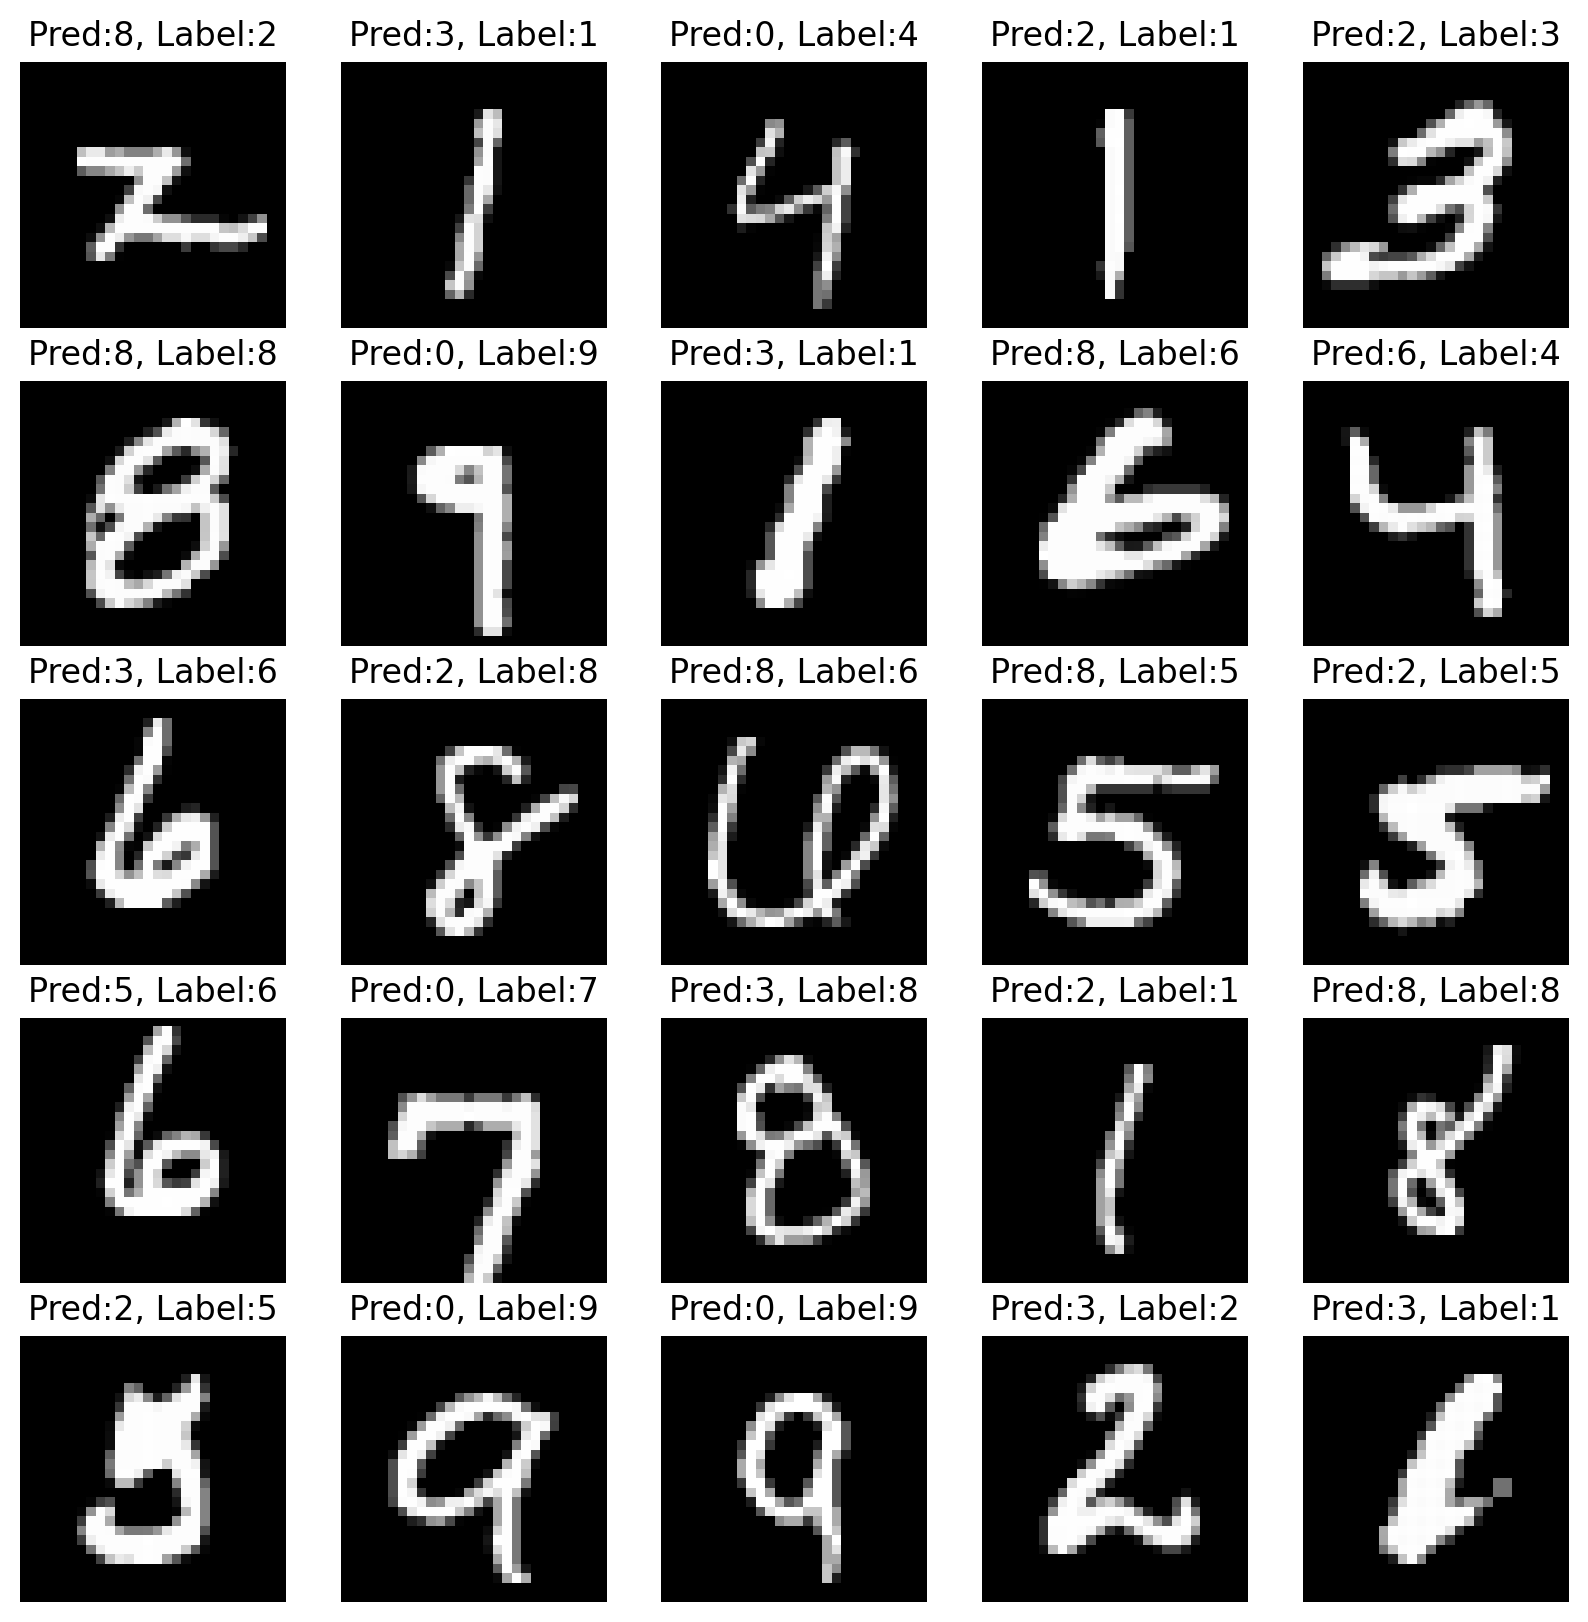

In [14]:
model.eval()
with torch.no_grad():
    n_sample = 25  # number of samples
    
    # n_sample개의 테스트 데이터를 랜덤하게 선택
    sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
    test_x = mnist_test.data[sample_indices]
    test_y = mnist_test.targets[sample_indices]

    # 모델에 입력으로 넣어서 예측값을 계산
    y_pred = model(test_x.view(-1, 1, 28, 28).float().to(device)).argmax(dim=1).cpu().numpy()

    
    # 5x5 grid로 테스트 이미지와 예측값 출력
    plt.figure(figsize=(10,10))
    for idx in range(n_sample):
        plt.subplot(5, 5, idx+1)  # 5x5 grid에서의 위치 지정
        plt.imshow(test_x[idx], cmap='gray')  # 이미지 출력
        plt.axis('off')  # x축과 y축의 눈금 출력하지 않음
        plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))  # 예측값과 실제값 출력
    plt.show()  # 그림 출력

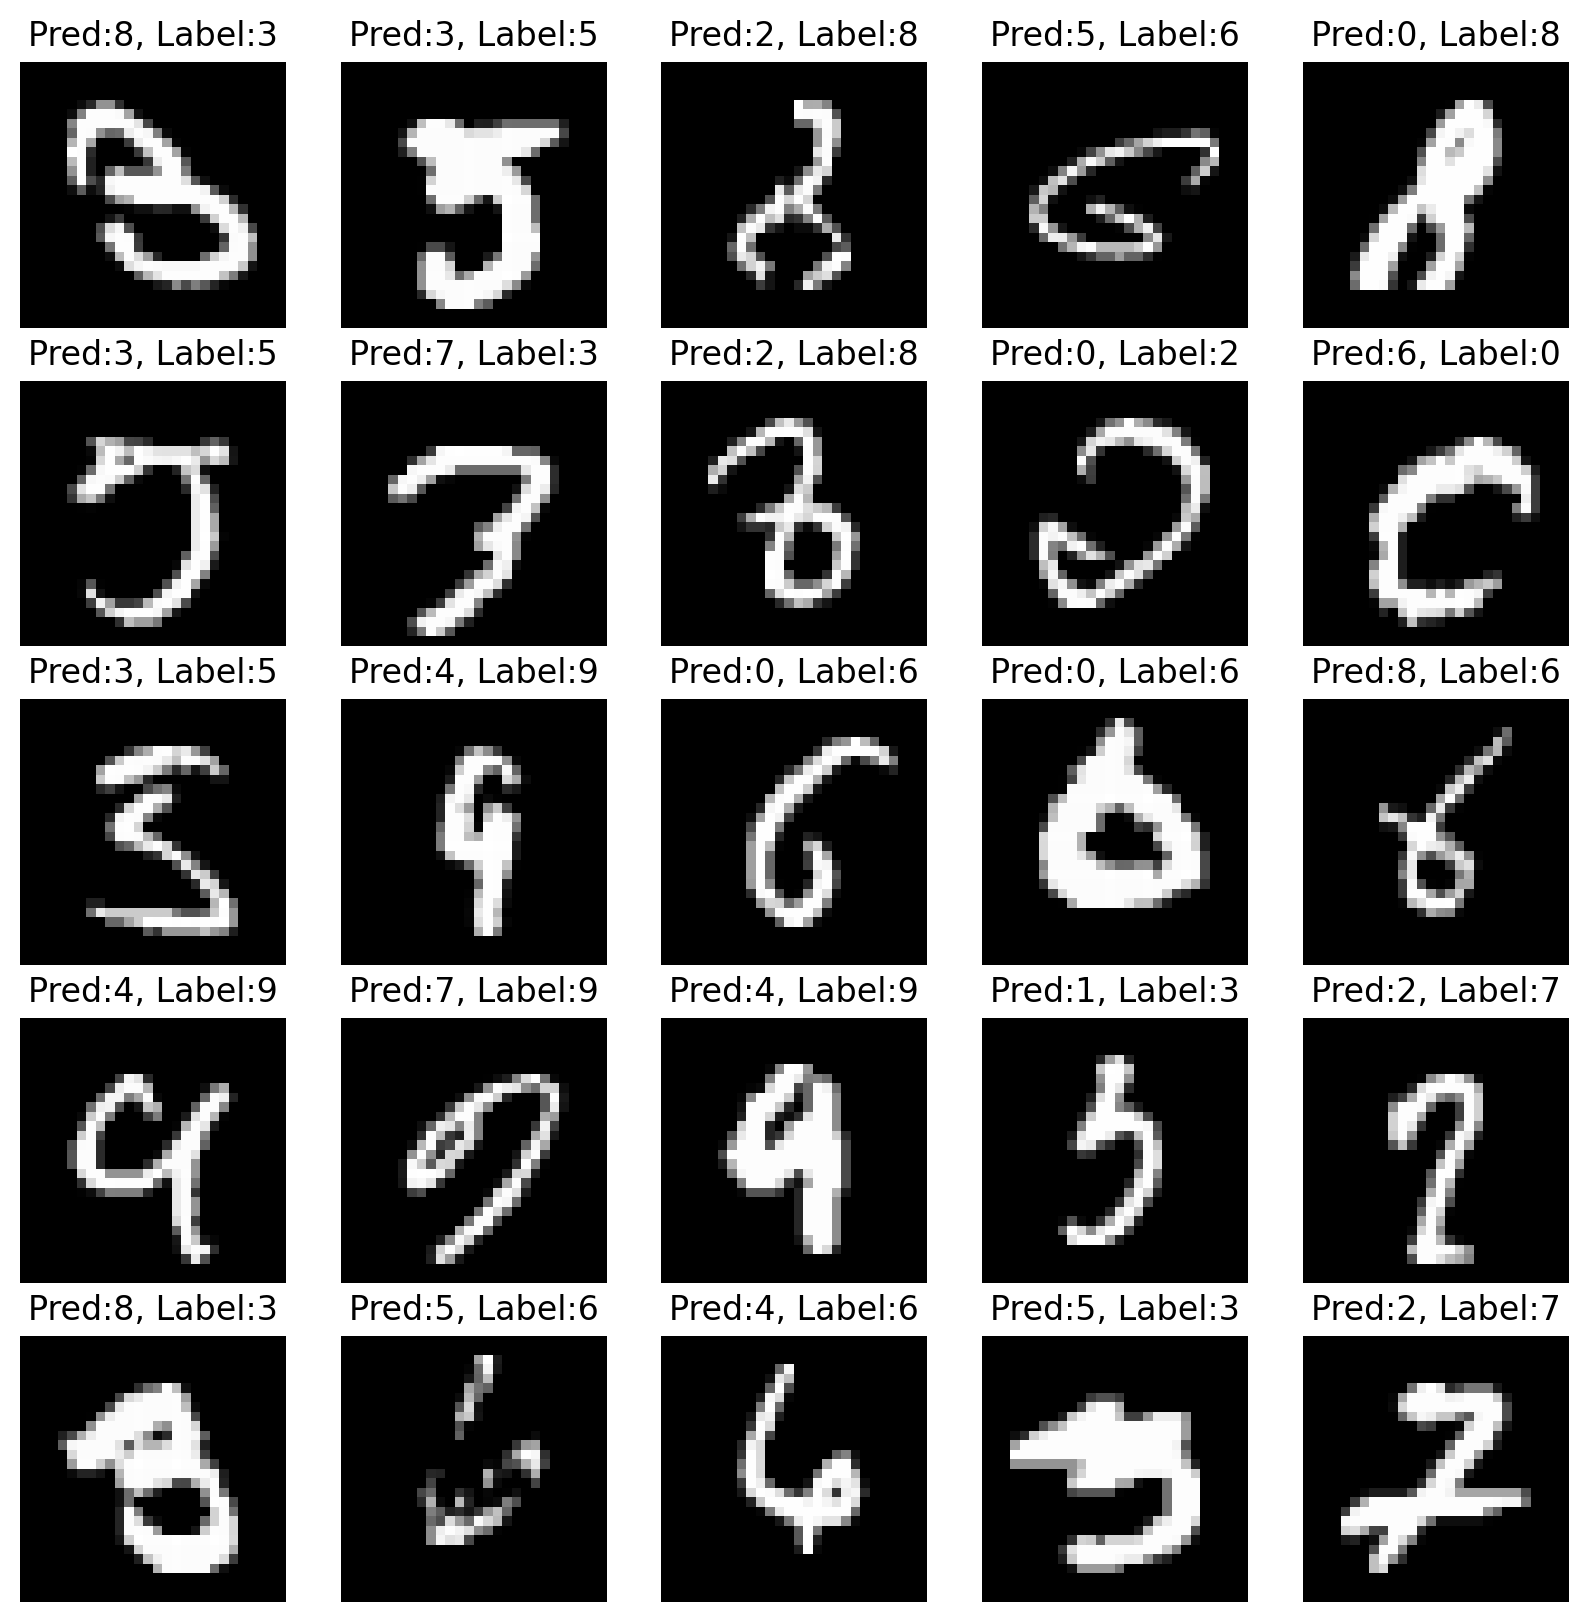

In [15]:
# 정답이 아닌 예측값을 가진 테스트 데이터를 랜덤하게 선택하여 출력
model.eval()
with torch.no_grad():
    n_sample = 25  # number of samples
    img, t, p = [], [], []
    for batch in test_iter:
        x, y = batch[0].to(device), batch[1].to(device)
        output = model(x)
        y_pred = output.argmax(dim=1)
        for i in range(len(y)):
            if y[i] != y_pred[i]:
                img.append(x[i].cpu())
                t.append(y[i].cpu())
                p.append(y_pred[i].cpu())
                if len(x) >= n_sample:
                    break
                
    plt.figure(figsize=(10,10))
    for idx in range(n_sample):
        plt.subplot(5, 5, idx+1)  # 5x5 grid에서의 위치 지정
        plt.imshow(img[idx].view(28,28), cmap='gray')  # 이미지 출력
        plt.axis('off')  # x축과 y축의 눈금 출력하지 않음
        plt.title("Pred:%d, Label:%d"%(p[idx],t[idx]))  # 예측값과 실제값 출력

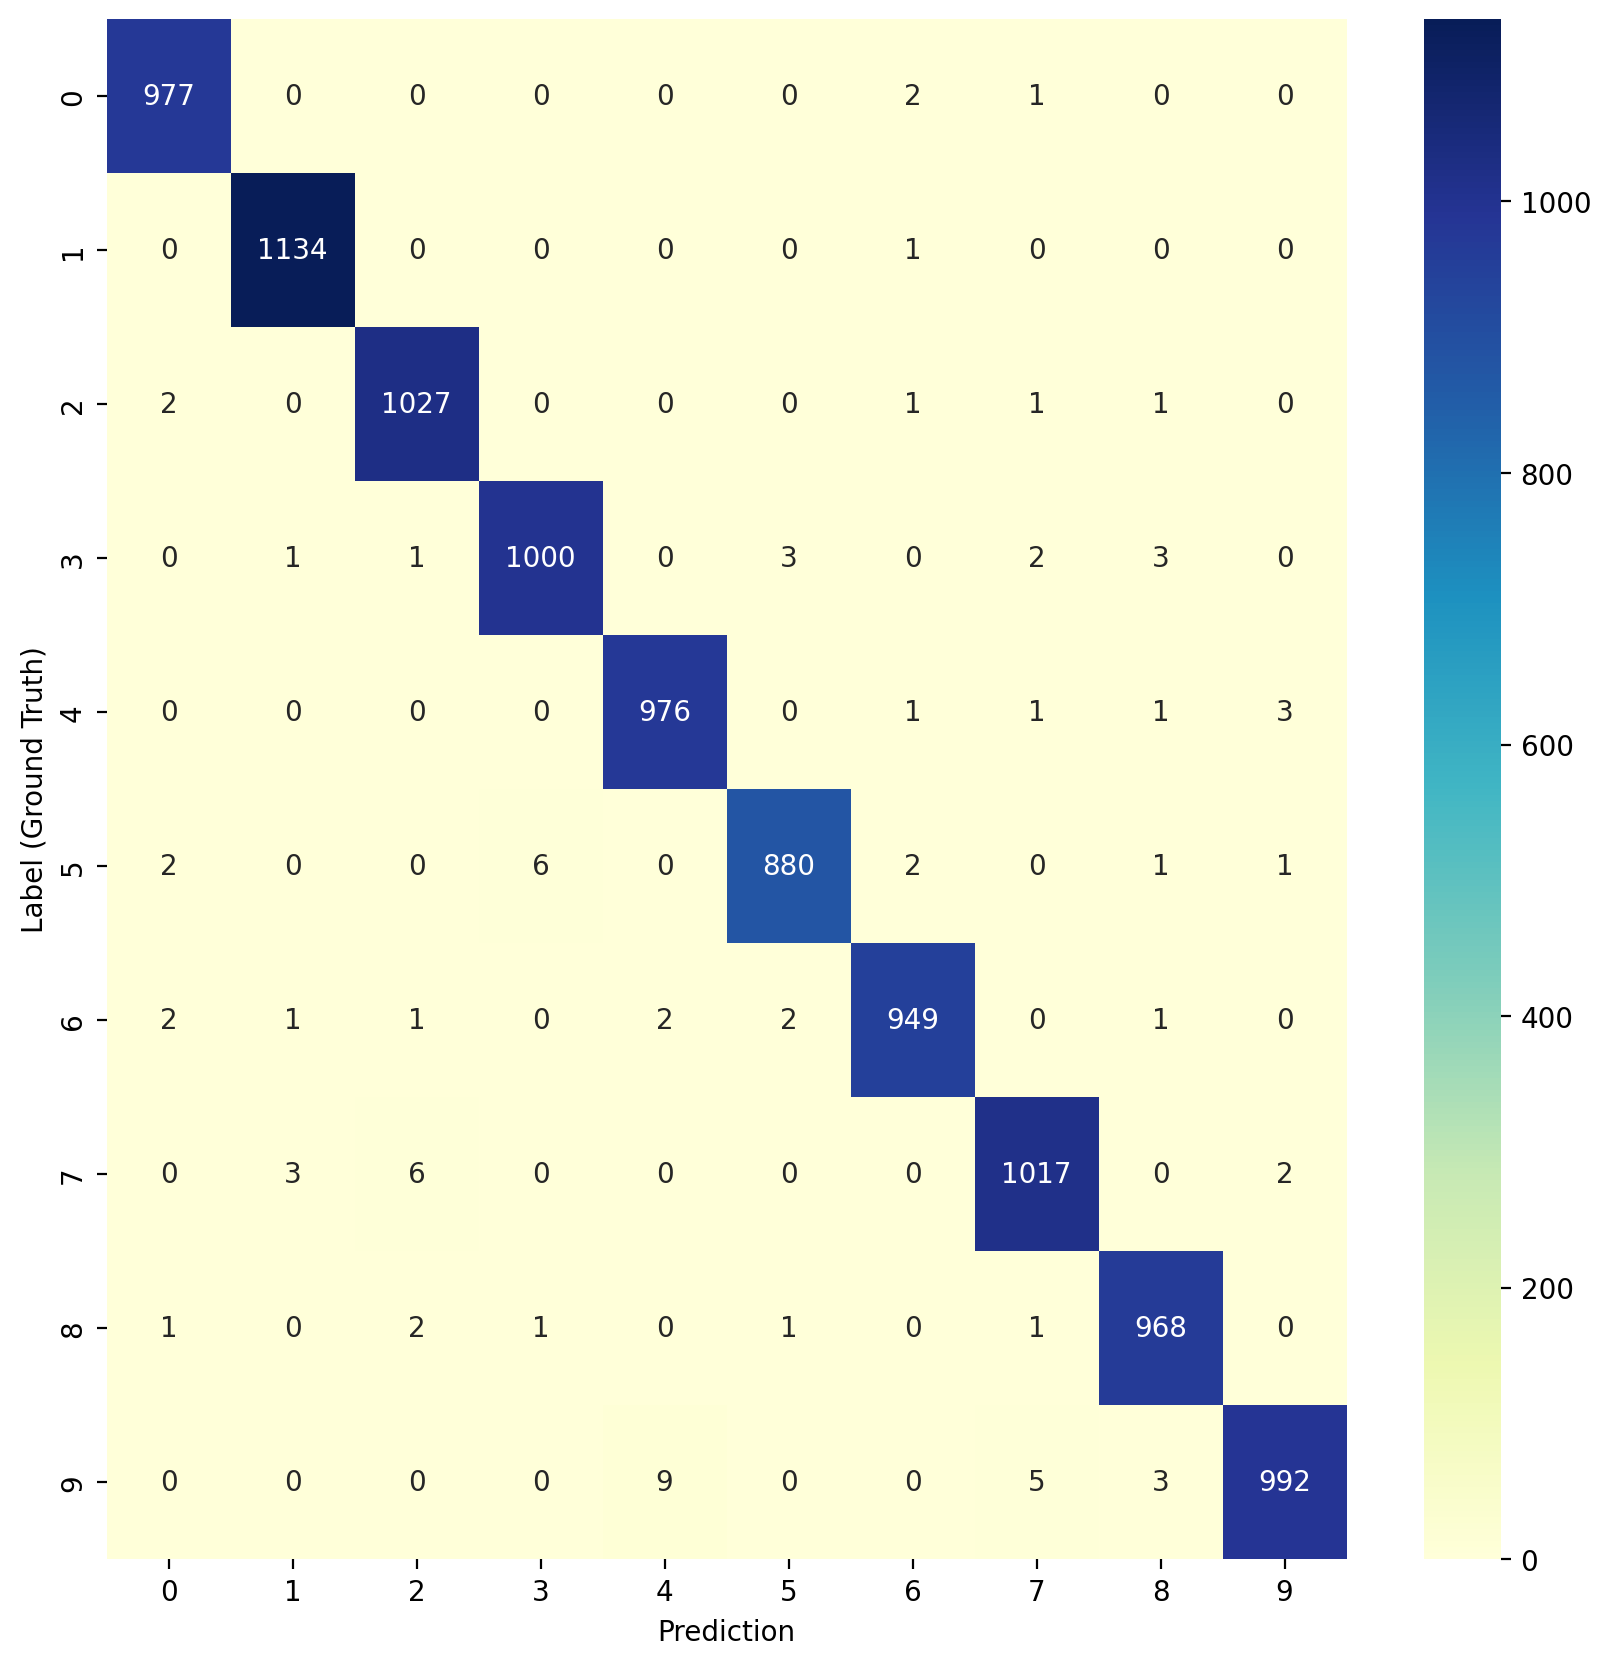

In [16]:
# confusion matrix 계산
model.eval()
with torch.no_grad():
    n_class = 10  # number of classes
    confusion_matrix = torch.zeros((n_class, n_class), dtype=torch.int64)
    for batch in test_iter:
        x, y = batch[0].to(device), batch[1].to(device)
        output = model(x)
        y_pred = output.argmax(dim=1)
        for i in range(len(y)):
            confusion_matrix[y[i], y_pred[i]] += 1
    
    # confusion matrix 출력 (pandas dataframe 사용, color map 사용)
    import pandas as pd
    import seaborn as sns
    plt.figure(figsize=(10,10))
    sns.heatmap(pd.DataFrame(confusion_matrix.numpy()),
                annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel('Prediction')
    plt.ylabel('Label (Ground Truth)')
    plt.show()
